In [1]:
import os
import json
from typing import TypedDict, Dict, Any, List
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langgraph.graph import StateGraph, END
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache



          ┌─────────────┐
          │   User       │
          │   Query      │
          └──────┬──────┘
                 ↓
          ┌─────────────┐
          │ Intent       │
          │ Classifier   │
          └──────┬──────┘
                 ↓
          ┌─────────────┐
          │ Decompose    │
          │ Query        │
          └──────┬──────┘
                 ↓
          ┌────────────────────┐
          │ Retrieve Chunks     │
          │  (FAISS + Weights) │
          └──────┬─────────────┘
                 ↓
        ┌───────────────────────────┐
        │ Docs:                     │
        │ • Company Overview        │
        │ • Competitor Analysis     │
        │ • SaaS Sales Q1           │
        │ • SaaS Sales Q2           │
        │ • FMCG Sales Q1           │
        │ • FMCG Sales Q2           │
        └──────────┬────────────────┘
                   ↓
          ┌───────────────┐
          │ GPT-4 Answer   │
          │ Structured Out │
          │ (Exec Summary, │
          │ Insights, Recs)│
          └───────────────┘


In [2]:
# ---------------------------
# STEP 1: Enable Cache for Speed
# ---------------------------
set_llm_cache(InMemoryCache())



In [ ]:
# ---------------------------
# STEP 2: API Key & Models
# ---------------------------
os.environ["OPENAI_API_KEY"] = ""

# Fast model for intent detection
llm_fast = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# High-quality model for final answer
llm_reasoning = ChatOpenAI(model="gpt-4", temperature=0)

embedding_model = OpenAIEmbeddings()

#


In [25]:

# STEP 3: Load and Chunk PDFs
# ---------------------------
data_folder = "data"
docs = []
for file in os.listdir(data_folder):
    if file.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(data_folder, file))
        docs.extend(loader.load())

# Split documents into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
chunks = splitter.split_documents(docs)



In [7]:
# ---------------------------
# STEP 4: Vector Store for Retrieval
# ---------------------------
vectorstore = FAISS.from_documents(chunks, embedding_model)



In [8]:
# ---------------------------
# STEP 5: Define State for LangGraph
# ---------------------------
class GraphState(TypedDict):
    query: str
    sub_queries: List[str]
    intent_info: Dict
    context: str
    answer: str



In [9]:
# ---------------------------
# STEP 6: Intent Classification Node
# ---------------------------
intent_prompt = PromptTemplate(
    input_variables=["query"],
    template="""
Classify the user query into JSON:
- intent: [overview | competitor_analysis | sales_saas | sales_fmcg | multi_doc_analysis]
- reasoning: short reason
- sectors: [SaaS, FMCG, Both]
- quarters: [Q1, Q2, Both, NA]

Query: "{query}"
Output only JSON.
"""
)
intent_chain = intent_prompt | llm_fast | StrOutputParser()



In [10]:
# ---------------------------
# STEP 7: Multi-hop Query Decomposition
# ---------------------------
decompose_prompt = PromptTemplate(
    input_variables=["query"],
    template="""
If the query is complex, break it into smaller sub-queries for analysis.
Return as JSON:
{{
  "sub_queries": ["question1", "question2", ...]
}}
Query: "{query}"
"""
)
decompose_chain = decompose_prompt | llm_fast | StrOutputParser()



In [11]:
# ---------------------------
# STEP 8: Weighted Retrieval
# ---------------------------
def weighted_retrieval(query: str, intent_info: Dict) -> str:
    results = vectorstore.similarity_search_with_score(query, k=12)
    boosted = []
    for doc, score in results:
        meta_path = doc.metadata.get("source", "").lower()
        if intent_info.get("sectors") == "SaaS" and "saas" in meta_path:
            score *= 0.7
        if intent_info.get("sectors") == "FMCG" and "fmcg" in meta_path:
            score *= 0.7
        if intent_info.get("quarters") == "Q1" and "q1" in meta_path:
            score *= 0.8
        if intent_info.get("quarters") == "Q2" and "q2" in meta_path:
            score *= 0.8
        boosted.append((doc.page_content, score))
    boosted.sort(key=lambda x: x[1])
    return "\n\n".join([text for text, _ in boosted[:5]])



In [16]:
# ---------------------------
# STEP 9: Answer Generation Node
# ---------------------------
response_prompt = ChatPromptTemplate.from_template("""
You are a Strategic Business Analyst.
Answer using ONLY the given context.

USER QUERY: {query}
CONTEXT:
{context}

Rules:
- Do NOT invent facts.
- If info missing, say "Not found in documents."
- Use this format:

### EXECUTIVE SUMMARY
- 3-4 bullets

### DETAILED INSIGHTS
- Explain with supporting facts

### STRATEGIC IMPLICATIONS
- Recommendations
""")
response_chain = response_prompt | llm_reasoning | StrOutputParser()


**1\. classify\_node**
----------------------

### **What it does**

*   Classifies the user query into:
    
    *   intent → Type of analysis (overview, competitor\_analysis, etc.)
        
    *   sectors → SaaS, FMCG, Both
        
    *   quarters → Q1, Q2, Both
        

### **Input**

*   state\["query"\] → Original user query.
    

### **Output**

*   state\["intent\_info"\] → JSON with intent details.
    

### **Relevance**

*   Guides retrieval to prioritize the correct sector and quarter.
    

### **Analogy**

*   Like a **travel agent** asking what type of trip you want (beach or mountains) before planning.
    

**2\. decompose\_node**
-----------------------

### **What it does**

*   Breaks a **complex query** into **smaller sub-queries** for multi-hop reasoning.
    

### **Input**

*   state\["query"\]
    

### **Output**

*   state\["sub\_queries"\] → List of sub-questions.
    

### **Relevance**

*   Helps handle complex queries like:
    
    *   _“Compare Q1 SaaS revenue with Q2 FMCG performance and competitor strategy.”_
        

### **Analogy**

*   Like a **chef breaking a recipe into steps** (chop veggies → boil pasta → prepare sauce).
    

**3\. retrieve\_node**
----------------------

### **What it does**

*   Retrieves relevant chunks for each sub-query:
    
    *   Uses **vector search** for semantic similarity.
        
    *   Applies **boosting** based on intent (sector/quarter).
        

### **Input**

*   state\["sub\_queries"\]
    
*   state\["intent\_info"\]
    

### **Output**

*   state\["context"\] → Combined chunks from most relevant documents.
    

### **Relevance**

*   Ensures information comes from the right sector and time period.
    

### **Analogy**

*   Like a **librarian bringing the right set of books** for your research question.
    

**4\. answer\_node**
--------------------

### **What it does**

*   Synthesizes:
    
    *   Original **query**.
        
    *   Combined **context**.
        
*   Generates **structured answer**:
    
    *   **Executive Summary**
        
    *   **Detailed Insights**
        
    *   **Strategic Implications**
        

### **Input**

*   state\["query"\]
    
*   state\["context"\]
    

### **Output**

*   state\["answer"\] → Final business-ready response.
    

### **Relevance**

*   Converts raw chunks into insights and recommendations.
    

### **Analogy**

*   Like a **consultant creating a final report** after analyzing multiple documents.
    

### ✅ **Flow in One Line:**

User Query → Classify → Decompose → Retrieve → Answer

In [17]:

# ---------------------------
# STEP 10: LangGraph Nodes
# ---------------------------
def classify_node(state: GraphState) -> GraphState:
    query = state["query"]
    raw_intent = intent_chain.invoke({"query": query})
    try:
        intent_info = json.loads(raw_intent)
    except:
        intent_info = {"intent": "multi_doc_analysis", "sectors": "Both", "quarters": "Both"}
    state["intent_info"] = intent_info
    return state

def decompose_node(state: GraphState) -> GraphState:
    query = state["query"]
    raw_decomp = decompose_chain.invoke({"query": query})
    try:
        sub_queries = json.loads(raw_decomp).get("sub_queries", [])
    except:
        sub_queries = []
    state["sub_queries"] = sub_queries if sub_queries else [query]
    return state

def retrieve_node(state: GraphState) -> GraphState:
    intent_info = state["intent_info"]
    combined_context = ""
    for q in state["sub_queries"]:
        combined_context += weighted_retrieval(q, intent_info) + "\n\n"
    state["context"] = combined_context
    return state

def answer_node(state: GraphState) -> GraphState:
    query = state["query"]
    context = state["context"]
    answer = response_chain.invoke({"query": query, "context": context})
    state["answer"] = answer
    return state



In [26]:
# ---------------------------
# STEP 11: Build LangGraph Workflow
# ---------------------------
graph = StateGraph(GraphState)
graph.add_node("classify", classify_node)
graph.add_node("decompose", decompose_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("answer", answer_node)

graph.set_entry_point("classify")
graph.add_edge("classify", "decompose")
graph.add_edge("decompose", "retrieve")
graph.add_edge("retrieve", "answer")
graph.add_edge("answer", END)

app = graph.compile()



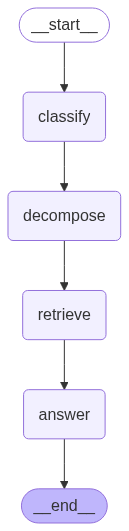

In [27]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [28]:
# ---------------------------
# STEP 12: Interactive Loop
# ---------------------------
while True:
    user_query = input("\nAsk your question (or 'exit'): ")
    if user_query.lower() == "exit":
        break

    initial_state: GraphState = {"query": user_query, "sub_queries": [], "intent_info": {}, "context": "", "answer": ""}
    result = app.invoke(initial_state)

    print("\n[Intent Info]:", result["intent_info"])
    print("\n[Sub-Queries]:", result["sub_queries"])
    print("\n### FINAL ANSWER ###\n")
    print(result["answer"])


Ask your question (or 'exit'):  give me the competitior analysis



[Intent Info]: {'intent': 'competitor_analysis', 'reasoning': 'need to analyze competitors', 'sectors': ['SaaS', 'FMCG', 'Both'], 'quarters': ['Q1', 'Q2', 'Both', 'NA']}

[Sub-Queries]: ['identify competitors', "analyze competitors' strengths and weaknesses", "evaluate competitors' market share", "assess competitors' pricing strategies"]

### FINAL ANSWER ###

### EXECUTIVE SUMMARY
- Beta Corp is a top-tier SaaS vendor with a diversified portfolio of cloud-based applications and a strong focus on AI-driven business intelligence. 
- Delta Technologies is a lean disrupter, focusing on cost-efficiency and zero-friction automation, targeting price-sensitive geographies and digitally hesitant SMB cohorts.
- The SaaS market is seeing aggressive AI adoption, with 78% of Tier-1 SaaS vendors introducing generative AI or predictive analytics features into their core offerings during Q1 2025.
- The market is also experiencing a pricing model evolution, with dynamic pricing algorithms and predict

KeyboardInterrupt: Interrupted by user